### a) Imports

In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import os
import simplejson
import sys
import numpy as np
from sklearn.datasets import load_svmlight_file

import loss_functions, make_plots
import scr, tr, sgd, saga    


### b) load data and initialize weights

In [2]:
#####################
#### Load  Data  ####
#####################

dataset_name='a9a' 

#logistic regression:
if dataset_name=='a9a':
    X, Y = load_svmlight_file('data/a9a')
    X = X.toarray()
    Y= [0 if e == -1 else e for e in Y]
    Y=np.array(Y)      
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(d)
    
#multinominal (softmax) regression:
elif dataset_name == 'mnist':
    import scipy 
    X, Y = load_svmlight_file('data/mnist')
    X = X.toarray()
    nC = len(np.unique(Y))    
    ## one-hot encoding of labels
    data   = np.ones(len(Y))
    indptr = np.arange(len(Y)+1)
    ground_truth = scipy.sparse.csr_matrix((data, Y, indptr))
    Y = ground_truth.todense() #gives a matrix with [Ground_Truth]i,j: is sample i in class j? (n x nC)
    d = X.shape[1]
    n = X.shape[0]
    w = np.zeros(nC*d)

#general function    
elif dataset_name=='rosenbrock':
    d=2
    n=1 
    w = np.zeros(d)

print ('Dataset', dataset_name, 'loaded')    
print ('n = ' + str(n) + ' d = ' + str(d))

Dataset a9a loaded
n = 32561 d = 123


### c) specify a loss, gradient, Hessian-vector-product and Hessian computations
- (latter only needed for hard case)
- functions need to have (w,X,Y,kwargs...) as input structure !

In [3]:
if dataset_name in {'a9a'}:
    loss_computation = loss_functions.logistic_loss
    gradient_computation = loss_functions.logistic_loss_gradient
    hessian_vector_computation = loss_functions.logistic_loss_Hv
    hessian_computation = loss_functions.logistic_loss_hessian
    
    # Additional arguments that are to be passed to the Loss, Gradient, etc. computations
    loss_args= {}
    loss_args['alpha'] = 1e-3 # regularizer

if dataset_name in {'mnist'}:
    loss_computation = loss_functions.softmax_loss
    gradient_computation = loss_functions.softmax_loss_gradient
    hessian_vector_computation = loss_functions.softmax_loss_Hv
    hessian_computation = loss_functions.softmax_loss_hessian
    
    loss_args= {}
    loss_args['alpha'] = 1e-3
    loss_args['n_classes'] = nC # for multiclass (softmax) regression

    
elif dataset_name == 'rosenbrock':
    loss_computation = loss_functions.rosenbrock_loss
    gradient_computation = loss_functions.rosenbrock_gradient
    hessian_vector_computation = loss_functions.rosenbrock_Hv
    hessian_computation = loss_functions.rosenbrock_hessian
    
    loss_args= {}

In [4]:
def show_plots(x_limits_time=None):
    list_params=[]
    list_loss=[]
    list_x=[]
    list_samples=[]
    
    log_scale=True
    
    over_time=True
    over_iterations=True
    over_epochs=True
    
    if SCR:
        list_loss.append(SCR_loss)
        list_x.append(SCR_x)
        list_samples.append(SCR_samples)
        list_params.append('SCR')
        
    if TR:
        list_loss.append(TR_loss)
        list_x.append(TR_x)
        list_samples.append(TR_samples)
        list_params.append('TR')
        
    if SGD:
        list_loss.append(SGD_loss)
        list_x.append(SGD_x)
        list_samples.append(SGD_samples)
        list_params.append('SGD')
    if SAGA:
        list_loss.append(SAGA_loss)
        list_x.append(SAGA_x)
        list_samples.append(SAGA_samples)
        list_params.append('SAGA')
        
    if over_time:
        make_plots.two_d_plot_time(list_loss,list_x,list_params,dataset_name, n, d, log_scale,x_limits=x_limits_time)
        
    if over_iterations:
        make_plots.two_d_plot_iterations(list_loss,list_x,list_params,dataset_name, n, d, log_scale)
        
    if over_epochs:
        make_plots.two_d_plot_epochs(list_loss,list_samples,list_params,dataset_name, n, d, log_scale)


### d) Set parameters and run methods

In [51]:
n_runs = 1 # repeat experiments to lower effect of randomness

# The following parameters are optional in the sense that default values are set if not specified.
opt = {}

### TR and SCR:
opt['penalty_increase_multiplier']=2.    # multiply by..
opt['penalty_derease_multiplier']=2.     # divide by..
opt['initial_penalty_parameter']=0.01
opt['initial_tr_radius']=1
opt['successful_treshold']=0.1
opt['very_successful_treshold']=0.9

opt['grad_tol']=1e-9
opt['n_iterations'] = 20

# Sampling
opt['Hessian_sampling']=True
opt['gradient_sampling']=False
opt['initial_sample_size_Hessian']=0.025
opt['initial_sample_size_gradient']=0.25
opt['subproblem_solver']='lanczos'
opt['unsuccessful_sample_scaling']=1.5
opt['sample_scaling_Hessian']=1
opt['sample_scaling_gradient']=1

# Subproblem 
opt['subproblem_solver_SCR']='lanczos' # alternatives: lanczos, cauchy_point, exact
opt['subproblem_solver_TR']='GLTR' # alternatives: GLTR, cauchy_point, exact, dog_leg, cg

opt['solve_each_i-th_krylov_space']=1   
opt['krylov_tol']=1e-1
opt['exact_tol']=1e-2
opt['keep_Q_matrix_in_memory']=True

### SGD:
opt['n_epochs_sgd']=10
opt['learning_rate_sgd']=1e-1 # This SGD implementation expects a constant step size
opt['batch_size_sgd']=0.001*n

### SAGA:
opt['n_epochs_saga']=10
opt['learning_rate_saga']=1e-2



######################
#### Run Methods #####
######################

SCR=True
TR= True
SGD= True
SAGA= True

if SCR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SCR_loss=[]
        SCR_x=[]
        (w_SCR,_timing, _loss, _samples)=scr.SCR(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation,hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SCR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SCR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SCR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if TR:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        TR_loss=[]
        TR_x=[]
        (w_TR,_timing, _loss, _samples)=tr.Trust_Region(w,loss_computation,gradient_computation,
                                                    Hv=hessian_vector_computation, hessian=hessian_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    TR_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    TR_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    TR_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SGD:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SGD_loss=[]
        SGD_x=[]
        (w_SGD,_timing, _loss, _samples)=sgd.SGD(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SGD_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SGD_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SGD_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)] 
    
if SAGA:
    loss_collector=[]
    timings_collector=[]
    samples_collector=[]
    
    for k in range(n_runs): 
        SAGA_loss=[]
        SAGA_x=[]
        (w_SAGA,_timing, _loss, _samples)=saga.SAGA(w,loss_computation,gradient_computation, X=X, Y=Y, opt=opt, **loss_args)
        loss_collector.append(_loss)
        timings_collector.append(_timing)
        samples_collector.append(_samples)

    SAGA_loss = [float(sum(col))/len(col) for col in zip(*loss_collector)]
    SAGA_x = [float(sum(col))/len(col) for col in zip(*timings_collector)]    
    SAGA_samples= [float(sum(col))/len(col) for col in zip(*samples_collector)]     

--- Subsampled Cubic Regularization ---

- Subproblem_solver: lanczos
- Hessian_sampling: True
- Gradient_sampling: False
- Sampling_scheme: adaptive 

Iteration 0: loss = 0.422207952742 norm_grad = 0.673770075892 time=  0.016 penalty= 0.005 stepnorm= 1.05133927991 Samples Hessian= 814 samples Gradient= 32561 

Iteration 1: loss = 0.355193893118 norm_grad = 0.151619014111 time=  0.016 penalty= 0.0025 stepnorm= 1.34364455659 Samples Hessian= 814 samples Gradient= 32561 

Iteration 2: loss = 0.337327847085 norm_grad = 0.0453615499189 time=  0.041 penalty= 0.00125 stepnorm= 1.15009565442 Samples Hessian= 814 samples Gradient= 32561 

Iteration 3: loss = 0.333821539306 norm_grad = 0.0134120708477 time=  0.028 penalty= 0.000625 stepnorm= 0.872278551454 Samples Hessian= 814 samples Gradient= 32561 

Iteration 4: loss = 0.333389331302 norm_grad = 0.00551349081973 time=  0.02 penalty= 0.0003125 stepnorm= 0.388221762946 Samples Hessian= 1182 samples Gradient= 32561 

Iteration 5: loss = 0.33334

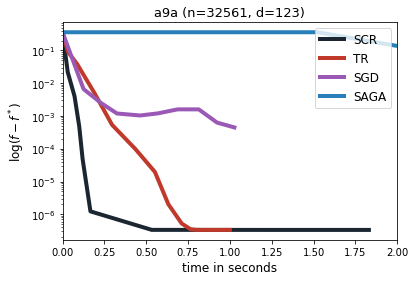

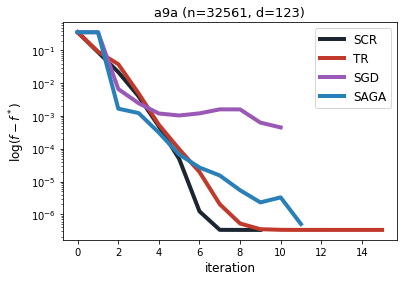

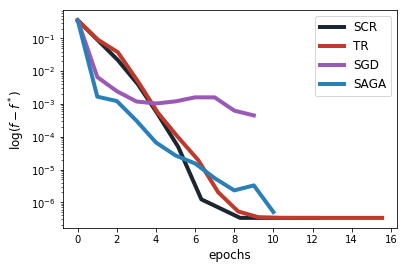

In [52]:
%matplotlib inline
show_plots(x_limits_time=(0,2))